In [175]:
import torch 
import torchvision 

import torchvision.transforms as transforms 
import matplotlib.pyplot as plt 
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from itertools import product
torch.set_printoptions(linewidth=120)

In [177]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0
0.12.0


In [153]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

labels: tensor([0, 1, 3, 5, 6, 0, 0, 9, 2, 9, 3, 0, 2, 8, 1, 1, 4, 2, 1, 8, 9, 4, 0, 8, 0, 1, 3, 5, 3, 8, 4, 1, 9, 0, 0, 3, 1,
        2, 1, 7, 7, 5, 8, 0, 2, 2, 1, 3, 8, 8, 6, 7, 2, 2, 3, 5, 1, 2, 2, 4, 3, 6, 8, 4, 2, 0, 3, 8, 6, 6, 9, 3, 5, 6,
        0, 4, 4, 2, 9, 7, 3, 2, 4, 5, 4, 0, 4, 6, 6, 1, 4, 1, 7, 2, 8, 5, 1, 3, 0, 5])


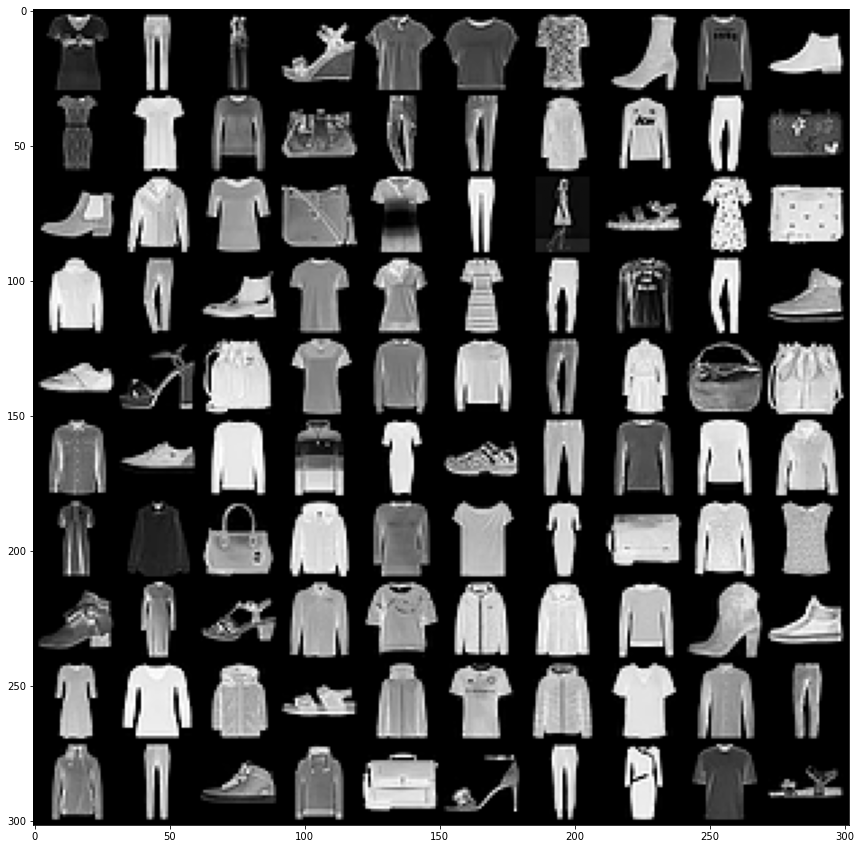

In [154]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid ,(1,2,0)))

print('labels:', labels)

In [155]:
torch.set_grad_enabled(True)

In [156]:
# Extend the nn.Module base class
# Define the layers as class attributes 
# Implement the forward() method 
class Classifier(nn.Module): 
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) # output layer, still Linear 
    def forward(self, t):
        # does the transformations, maps input tesnor to output tensor
        # (1) Input layer - i dentity function, usually not defined explicitly 
#         t = t
        
        # (2) Hidden conv layer 
        t = self.conv1(t)
        # Relu and pooling operations are not 'layers' because they don't have weights
        t = F.relu(t) 
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) Hidden conv layer 
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) Hidden linear layer 
        t = t.reshape(-1, 12 * 4 * 4) #4*4 is H and W of each of the 12 output channels, reduced from 28*28
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        
        # (6) Output layer 
        t = self.out(t)
        
        return t

In [157]:
# sample = next(iter(train_set))
# image, label = sample
# image.shape

In [158]:
# image.unsqueeze(0).shape
# # image shape needs to be batch_size x in_channels x H x W

In [159]:
# pred = network(image.unsqueeze(0))

In [160]:
# pred.shape

In [161]:
# label

In [162]:
# pred.argmax(dim=1)

In [163]:
# F.softmax(pred, dim=1)

In [164]:
# preds = network(images)

In [165]:
# pred.shape

In [166]:
# preds

In [167]:
# preds.argmax(dim=1)

In [168]:
# labels

In [169]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [170]:
# get_num_correct(pred, labels)

In [171]:
'''Training procedure:
1. Get batch from network
2. Pass batch to network
3. Calculate loss (dif between pred and actual) using loss function
4. Calculate gradient of loss w.r.t network weights 
5. Update weights using gradient to reduce the loss using optimization algorithms
6. Repeat steps 1-5 until one epoch is completed
7. Repeat steps 1-6 for as many epochs as needed to get desired level of accuracy'''

'Training procedure:\n1. Get batch from network\n2. Pass batch to network\n3. Calculate loss (dif between pred and actual) using loss function\n4. Calculate gradient of loss w.r.t network weights \n5. Update weights using gradient to reduce the loss using optimization algorithms\n6. Repeat steps 1-5 until one epoch is completed\n7. Repeat steps 1-6 for as many epochs as needed to get desired level of accuracy'

In [ ]:
parameters = dict(
    lr = [0.01, 0.001],
    batch_size = [10, 100, 1000],
    shuffle = [True, False]
)

param_values = [v for v in parameters.values()]

In [184]:
batch_size = 100
lr = 0.01
epochs = 50

network = Classifier()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

for lr, batch_size, shuffle in product(*param_values):
    comment = f' batch_size={batch_size} lr={lr} shuffle={shuffle}' 
    tb = SummaryWriter(comment=comment)
    tb.add_image('images', grid)
    tb.add_graph(network, images)

# Dataloader wraps data and gives us access to it and query capabilites
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True) 
optimizer = optim.Adam(network.parameters(), lr=lr) # network.parameters() returns all the weights of the network

for epoch in range(epoch):
    total_loss = 0
    total_correct = 0

    # batch = next(iter(train_loader)) # Pulls batch from dataloader
    for batch in train_loader:
        # Unpacks images and labels from that batch 
        images, labels = batch # gives 2 tensors, tensor of images and corresponding tensor of labels 

        preds = network(images)
        loss = F.cross_entropy(preds, labels) #Returns loss tensor 

        optimizer.zero_grad()
        loss.backward() # Calculate gradients using backpropogation
        optimizer.step() # Updates weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
    
    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Number Correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)
    
#     tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
#     tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
#     tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)
    for name, weight in network.named_parameters():
        print(f'{name}.grad', weight.grad.shape)
    
    print("epoch: ", epoch, "total_correct: ", total_correct, "loss: ", total_loss)
    
tb.close()

epoch:  0 total_correct:  47524 loss:  334.0620346516371
epoch:  1 total_correct:  51489 loss:  227.05121555924416
epoch:  2 total_correct:  52273 loss:  207.46715261042118
epoch:  3 total_correct:  52787 loss:  195.33018903434277
epoch:  4 total_correct:  52852 loss:  191.56860544532537
epoch:  5 total_correct:  53137 loss:  185.88337845355272
epoch:  6 total_correct:  53221 loss:  183.40752865374088
epoch:  7 total_correct:  53246 loss:  182.68620951473713
epoch:  8 total_correct:  53426 loss:  178.9783877581358
epoch:  9 total_correct:  53619 loss:  174.66462506353855


In [173]:
# print('loss1: ', loss.item())
# preds = network(images)
# loss = F.cross_entropy(preds, labels)
# print('loss2: ', loss.item())

0.76375